<a href="https://colab.research.google.com/github/erick-arango/Proyecto_Introduccion_IA/blob/main/03_modelo_con_preprocesado_de_tal_forma_y_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================================================
# 03 - modelo con preprocesado y LightGBM
# =========================================================

# Instalar lightgbm si no está presente (solo en entornos que no lo traen)
try:
    import lightgbm as lgb
except Exception as e:
    print("lightgbm no encontrado. Instalando...")
    !pip install -q lightgbm
    import lightgbm as lgb

# Importaciones
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

print("Librerías cargadas.")


Librerías cargadas.


In [ ]:
if not os.path.exists("train_clean.csv"):
    raise FileNotFoundError("❌ No se encontró train_clean.csv. Sube el archivo.")

train = pd.read_csv("train_clean.csv")
print("Dataset cargado. Shape:", train.shape)
train.head()


Dataset cargado. Shape: (692500, 70)


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4,E_VALORMATRICULAUNIVERSIDAD_num,E_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones,...,F_EDUCACIONMADRE_Primaria incompleta,F_EDUCACIONMADRE_Secundaria (Bachillerato) completa,F_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE_Técnica o tecnológica completa,F_EDUCACIONMADRE_Técnica o tecnológica incompleta,F_EDUCACIONMADRE_no info,RENDIMIENTO_GLOBAL_alto,RENDIMIENTO_GLOBAL_bajo,RENDIMIENTO_GLOBAL_medio-alto,RENDIMIENTO_GLOBAL_medio-bajo
0,0.914049,0.966667,0.316790,0.133333,0.490107,0.427105,0.968750,0.804217,0.828571,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.652244,0.966667,0.262936,0.100000,0.473364,0.441478,0.912500,0.795181,0.485714,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.311706,0.666667,0.864836,0.133333,0.452055,0.439425,0.953125,0.795181,0.485714,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.475446,0.400000,0.014784,0.866667,0.738204,0.353183,0.787500,0.572289,0.657143,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.999743,0.966667,0.957761,0.033333,0.480974,0.476386,0.890625,0.885542,0.485714,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
target_cols = [
    'RENDIMIENTO_GLOBAL_alto',
    'RENDIMIENTO_GLOBAL_bajo',
    'RENDIMIENTO_GLOBAL_medio-alto',
    'RENDIMIENTO_GLOBAL_medio-bajo'
]

for col in target_cols:
    if col not in train.columns:
        raise ValueError(f"❌ La columna dummy {col} NO existe en el dataset. Revisa el archivo.")

print("✔ Columnas dummy detectadas correctamente:")
print(target_cols)


✔ Columnas dummy detectadas correctamente:
['RENDIMIENTO_GLOBAL_alto', 'RENDIMIENTO_GLOBAL_bajo', 'RENDIMIENTO_GLOBAL_medio-alto', 'RENDIMIENTO_GLOBAL_medio-bajo']


In [ ]:
# Filas donde todas las dummies son 0 (no tienen etiqueta válida)
mask_invalid = (train[target_cols].sum(axis=1) == 0)
print("Filas inválidas sin etiqueta:", mask_invalid.sum())

if mask_invalid.sum() > 0:
    train = train[~mask_invalid].reset_index(drop=True)

# Reconstruir TARGET
mapa = {
    'RENDIMIENTO_GLOBAL_bajo': 0,
    'RENDIMIENTO_GLOBAL_medio-bajo': 1,
    'RENDIMIENTO_GLOBAL_medio-alto': 2,
    'RENDIMIENTO_GLOBAL_alto': 3
}

train["TARGET"] = train[target_cols].idxmax(axis=1).map(mapa)

print("Distribución final del TARGET:")
print(train["TARGET"].value_counts())


Filas inválidas sin etiqueta: 0
Distribución final del TARGET:
TARGET
3    175619
0    172987
1    172275
2    171619
Name: count, dtype: int64


In [ ]:
X = train.drop(columns=target_cols + ["TARGET"])
y = train["TARGET"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (692500, 66)
y shape: (692500,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✔ División hecha:")
print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)


✔ División hecha:
X_train: (554000, 66)
X_val  : (138500, 66)


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

print("Entrenando modelo LightGBM ULTRA LIGERO...")

lgb_model = LGBMClassifier(
    n_estimators=120,       # valor fijo seguro (rápido)
    max_depth=6,
    learning_rate=0.15,
    num_leaves=20,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="multiclass",
    num_class=4,
    n_jobs=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="multi_logloss",
)

preds = lgb_model.predict(X_val)
print("Accuracy validación:", accuracy_score(y_val, preds))

# ============================
# ENTRENAR MODELO FINAL
# ============================

print("\nEntrenando modelo final con TODO el dataset...")

lgb_final = LGBMClassifier(
    n_estimators=120,       # usar el mismo número
    max_depth=6,
    learning_rate=0.15,
    num_leaves=20,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="multiclass",
    num_class=4,
    n_jobs=-1
)

lgb_final.fit(X, y)

print("Modelo final entrenado correctamente.")


Entrenando modelo LightGBM ULTRA LIGERO...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1548
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 66
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.371993
Accuracy validación: 0.43103249097472923

Entrenando modelo final con TODO el dataset...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

In [ ]:
# =========================================================
# PREPROCESAMIENTO DEL TEST (idéntico al del train)
# =========================================================

import pandas as pd
import numpy as np

# Cargar test.csv sin limpiar
if not os.path.exists("test.csv"):
    raise FileNotFoundError("Debes subir test.csv igual que train.csv")

test_raw = pd.read_csv("test.csv")
test = test_raw.copy()

print("Test original:", test.shape)

# =============================
# 1. Tratamiento de matrícula
# =============================
if 'E_VALORMATRICULAUNIVERSIDAD' in test.columns:
    cmap = {
        'Entre 1 millón y menos de 2.5 millones': 1.75,
        'Entre 2.5 millones y menos de 4 millones': 3.25,
        'Menos de 500 mil': 0.25,
        'Entre 500 mil y menos de 1 millón': 0.75,
        'Entre 4 millones y menos de 5.5 millones': 4.75,
        'Más de 7 millones': 7.75,
        'Entre 5.5 millones y menos de 7 millones': 6.25,
        'No pagó matrícula': 0,
        'no info': -1
    }
    test['E_VALORMATRICULAUNIVERSIDAD'] = test['E_VALORMATRICULAUNIVERSIDAD'].fillna('no info')
    test['E_VALORMATRICULAUNIVERSIDAD_num'] = test['E_VALORMATRICULAUNIVERSIDAD'].map(lambda x: cmap.get(x, -1))

# =============================
# 2. Limpieza general categorías
# =============================
for col in test.columns:
    if test[col].dtype == object:
        test[col] = test[col].replace({'No sabe': 'no info', 'No Aplica': 'no info'})
        moda = test[col].mode().iloc[0]
        test[col] = test[col].fillna(moda)

# =============================
# 3. One-hot encoding exacto
# =============================
# Importante: usar las MISMAS columnas creadas en train_clean
train_cols = list(train.columns)

# quitar TARGET del train
train_cols = [c for c in train_cols if c != "TARGET"]

# aplicar dummies al test
test = pd.get_dummies(test, dtype=int)

# asegurar que test tenga las mismas columnas que train
for col in train_cols:
    if col not in test.columns:
        test[col] = 0

# dejar solo columnas del train
test = test[train_cols]

print("Test preprocesado final:", test.shape)

# =============================
# 4. Guardar test_clean.csv
# =============================
test.to_csv("test_clean.csv", index=False)
print("Archivo guardado: test_clean.csv")


Test original: (296786, 20)
Test preprocesado final: (296786, 70)
Archivo guardado: test_clean.csv


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

print("Entrenando modelo LightGBM")

lgb_model = LGBMClassifier(
    n_estimators=80,          # antes 500 → esto lo hace MUCHO más rápido
    max_depth=6,              # árboles poco profundos → menos RAM
    learning_rate=0.15,       # un poco más alto para compensar menos árboles
    num_leaves=20,            # tamaño moderado → reduce RAM
    subsample=0.7,
    colsample_bytree=0.7,
    objective="multiclass",
    num_class=4,
    n_jobs=-1                 # usa varios núcleos
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="multi_logloss",
)

# Predicción
preds = lgb_model.predict(X_val)
acc = accuracy_score(y_val, preds)

print("Accuracy validación:", acc)


Entrenando modelo LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1548
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 66
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.371993
Accuracy validación: 0.42690974729241876


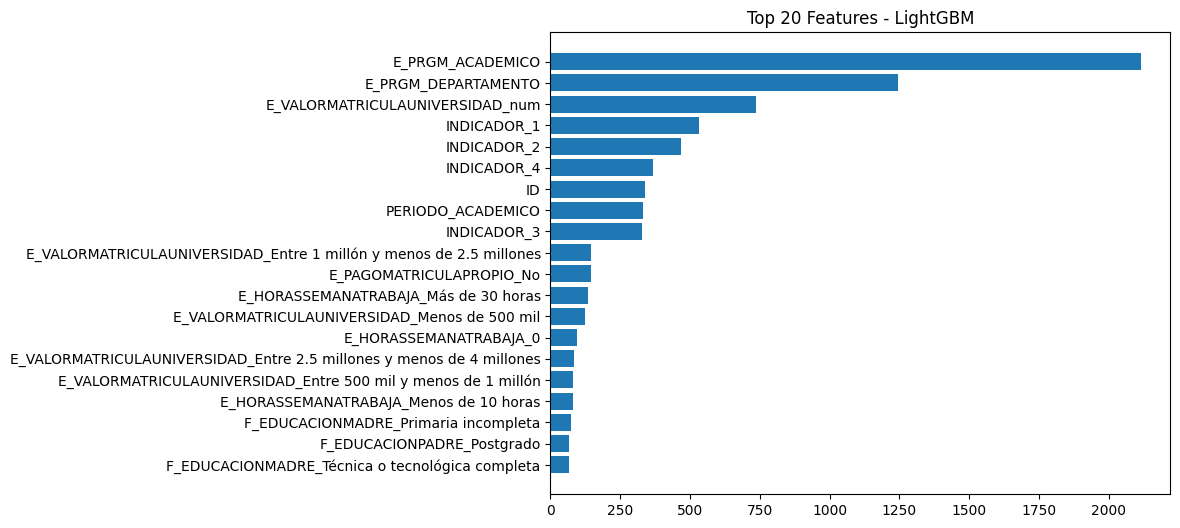

In [ ]:
fi = pd.DataFrame({
    "feature": X.columns,
    "importance": lgb_model.feature_importances_
}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.title("Top 20 Features - LightGBM")
plt.show()


In [ ]:
# ENTRENAR MODELO FINAL (con n_estimators fijo y seguro)
lgb_final = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=4,
    n_estimators=300,      # Número fijo (estable y recomendado)
    learning_rate=0.05,
    num_leaves=64,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

lgb_final.fit(X, y)
print("Modelo final entrenado correctamente.")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1548
[LightGBM] [Info] Number of data points in the train set: 692500, number of used features: 66
[LightGBM] [Info] Start training from score -1.387092
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Info] Start training from score -1.395031
[LightGBM] [Info] Start training from score -1.371991
Modelo final entrenado correctamente.


In [ ]:
if not os.path.exists("test_clean.csv"):
    raise FileNotFoundError("Falta test_clean.csv (preprocesado igual que train).")

test = pd.read_csv("test_clean.csv")
print("Test cargado. Shape:", test.shape)


Test cargado. Shape: (296786, 70)


In [ ]:
# Asegurar que test tenga todas las columnas de X
missing = [c for c in X.columns if c not in test.columns]
extra   = [c for c in test.columns if c not in X.columns and c != "ID"]

print("Columnas faltantes en test:", missing)
print("Columnas extra en test:", extra)

# Agregar faltantes
for col in missing:
    test[col] = 0

# Dejar solo las columnas de X, en el mismo orden
test = test[X.columns]


Columnas faltantes en test: []
Columnas extra en test: ['RENDIMIENTO_GLOBAL_alto', 'RENDIMIENTO_GLOBAL_bajo', 'RENDIMIENTO_GLOBAL_medio-alto', 'RENDIMIENTO_GLOBAL_medio-bajo']


In [ ]:
preds_test = lgb_final.predict(test)

inv = {0: "bajo", 1: "medio-bajo", 2: "medio-alto", 3: "alto"}
preds_labels = [inv[int(p)] for p in preds_test]

test_ids = pd.read_csv("test_clean.csv")["ID"]

submission = pd.DataFrame({
    "ID": test_ids,
    "RENDIMIENTO_GLOBAL": preds_labels
})

submission.to_csv("submission_modelo03_lightgbm.csv", index=False)
print("Archivo creado: submission_modelo03_lightgbm.csv")
submission.head()


Archivo creado: submission_modelo03_lightgbm.csv


,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,alto
2,499179,alto
3,782980,medio-bajo
4,785185,alto
